# One-Hot Encoded Char-Level Recurrent Model

Testing onnx saving.

In [1]:
# 'abstract' or 'title'
text_field = 'title'

# Imports and Setup

Imports and colab setup

In [2]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb --upgrade
!pip install pytorch-lightning==1.4.9 # v1.5.0 breaks wandb sweeps.
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn


import math
import pandas as pd
import numpy as np
import torch
pd.set_option(u'float_format', '{:f}'.format)

# pl and wandb installation and setup.
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb

In [3]:
wandb.login()

wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


True

Google drive access

In [4]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import models, loaders, and utility functions from our external package:

In [5]:
import arxiv_vixra_models as avm

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [6]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n",f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

GPU
--------------------------------------------------
 Thu Nov  4 16:07:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Copy data to CWD and read in with pandas.

In [7]:
# Copy data and dictionary of chars to cwd
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
chars_file_name = 'normalized_char_set.feather'
chars_path = FOLDERNAME + SUBDIR + chars_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{chars_path}' .

In [8]:
# load with pd
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
chars_df = pd.read_feather(chars_file_name)

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel.  **If the notebook 

In [9]:
from requests import get
project_str = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
project_str = project_str.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(project_str)

onnx_write_test


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [10]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[text_field], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect using `print` and `to_string()` to avoid colab javascript errors

In [11]:
print(train_data_df.head().to_string())

                                                                                         title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [12]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                 title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    abstract source
0                             

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [13]:
# Data was prepared with a max of 2048 chars for abstracts and 128 for titles.
seq_len = 2048 if text_field == 'abstract' else 128
model_args_dic = {'seq_len': seq_len,
              'num_layers': 2,
              'bidirectional': True,
              'rnn_type': 'GRU',
              'hidden_size': 128,
              'dropout': None,
              }
# The batch size we set here determines the number of datapoints used
# in the histogram that avm.WandbOneHotTextCallback logs
data_args_dic = {'seq_len': seq_len,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'chars': chars_df, 
                 'text_column': text_field,
                 'check_normalization': False,
                 'num_workers': num_processors,
                 'batch_size': 512,
                 'pin_memory': is_cuda_available,
                 'persistent_workers': True
                 }

Small test run.

In [14]:
small_example_data_module = avm.OneHotCharDataModule(**{**data_args_dic, **{'sample_size': data_args_dic['batch_size']}})
small_example_data_module.setup()
small_example_loader = small_example_data_module.train_dataloader()
small_example_inputs, small_example_targets = next(iter(small_example_loader))
# Print the first few input texts
for tensor, source in zip(small_example_inputs[:3], small_example_targets[:3]):
    stripped_text = avm.one_hot_decoding(tensor, chars_file_name)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
# Test the model        
small_example_model = avm.LitOneHotCharRecurrent(input_size=len(chars_df),
                                             **model_args_dic)
small_example_preds, small_example_losses, _ = small_example_model.preds_losses_hiddens(small_example_inputs, small_example_targets)
print('\npreds shape:', small_example_preds.shape, '\n')
print('\nactual loss:', small_example_losses.item(), '\n')
print('\nexpected approx loss', -math.log(.5), '\n')

text: incremental search space construction for machine learning pipeline synthesis
len: 77
source: 0
text: resistive hystersis effects in perovskite oxide - based heterostructure junctions
len: 81
source: 0
text: neutronics analysis for msr cell with different fuel salt channel geometry
len: 74
source: 0

preds shape: torch.Size([512, 1]) 


actual loss: 0.6942142844200134 


expected approx loss 0.6931471805599453 



For logging purposes, take another sample from the validation set which will be be used to visualize predictions.

In [15]:
val_sample  = next(iter(small_example_data_module.val_dataloader()))
val_sample_text = [avm.one_hot_decoding(input, chars_file_name) for input in val_sample[0]]
print(*val_sample_text[:3], sep='\n')

disordered fermions , extra dimensions and a solvable yang - mills theory
the fundamental role of proper time in general relativity and in quantum mechanics
conundrums overlooked in physics for evermore . . .


# Single, Local Model Training

Train a single model with the hyperparameters chosen in `data_args_dic` and `model_args_dic` which we can then feed examples.

In [16]:
# local_model_args_dic = {'seq_len': seq_len,
#               'num_layers': 2,
#               'bidirectional': True,
#               'rnn_type': 'GRU',
#               'truncated_bptt_steps': None,
#               'hidden_size': 128,
#               'dropout': None,
#               'lr': 1e-3,
#               'save_best_models_wandb': True,
#               'best_model_metric': 'val_acc'
#               }

# local_data_args_dic = {**data_args_dic,
#                        **{'batch_size': 32,
#                           'sample_size': .1}} # Only work with ten percent of data for speed.
                       
# local_trainer_dic = {'gpus': -1 if is_cuda_available else 0,
#                      'logger': WandbLogger(),
#                      'max_epochs': 5,
#                      'stochastic_weight_avg': True,
#                      'log_every_n_steps': 50,   
#                      'callbacks': [avm.WandbOneHotTextCallback(val_sample=val_sample,
#                                                                chars=chars_df,
#                                                                labels=('arxiv', 'vixra'))],                                   
#                }
# # Uncomment to sync run results with wandb.
# wandb.init(project=project_str,
#            config=local_model_args_dic,
#            group='test',
#            name='test',
#            )

In [17]:
# local_data_module = avm.OneHotCharDataModule(**local_data_args_dic)
# local_model = avm.LitOneHotCharRecurrent(input_size=len(chars_df),
#                                          **local_model_args_dic)
# local_trainer = Trainer(**local_trainer_dic)
# local_trainer.fit(local_model, datamodule=local_data_module)

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyperparam_dic`.
* `fixed_hyperparam_dic` is eventually merged with the hyperparameter dictionary for those hyperparameters included in `sweep_config` which is generated by `wandb`, with the result passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.

In [18]:
fixed_hyperparam_dic = {'seq_len': seq_len,
                        'num_layers': 2,
                        'bidirectional': True,
                        'rnn_type': 'GRU',
                        'truncated_bptt_steps': None,
                        'hidden_size': 128,
                        'dropout': None,
                        'lr': 1e-3,
                        'save_best_models_wandb': True,
                        'best_model_metric': 'val_acc'
                        }

sweep_config = {'method': 'random'}
sweep_config['early_terminate'] = {'type': 'hyperband',
                                    'min_iter': 3
                                   }
sweep_config['metric'] = {'name': 'val_loss',
                           'goal': 'minimize'
                           }
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': math.log(1e-5),
                                      'max': math.log(1e-3)
                                      }
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyperparam_dic` for logging purposes.

In [19]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyperparam_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyperparam_dic['batch_size'] = 512 #2 **10

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 2,
               'stochastic_weight_avg': True
               }
fixed_hyperparam_dic = {**fixed_hyperparam_dic, **trainer_dic}
def sweep_iteration():
    # Group by various properties
    group_str_elements = [fixed_hyperparam_dic['rnn_type'],
                          f"{'-bidirectional' if fixed_hyperparam_dic['bidirectional'] else ''}",
                          f"-hidden_size_{fixed_hyperparam_dic['hidden_size']}"
                          f"-{fixed_hyperparam_dic['num_layers']}_layers",
                          f"-{fixed_hyperparam_dic['max_epochs']}_epochs"]
    group_str = ''.join(group_str_elements)
    with wandb.init(group=group_str) as run:
        data = avm.OneHotCharDataModule(**data_args_dic)
        config = wandb.config
        # Merge config with model_args_dic
        config = {**fixed_hyperparam_dic, **config}
        # Passing wandb.config to the Model passes the `parameters` key from sweep_config.
        model = avm.LitOneHotCharRecurrent(input_size=len(chars_df), **config)
        # Overwrite the random run names chosen by wandb.
        name_str_elements = [f"lr_{config['lr']:.3E}",
                             f"{'-dropout_' + str(config['dropout']) if config['dropout'] else ''}"]
        name_str = ''.join(name_str_elements)
        run.name = name_str
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[avm.WandbOneHotTextCallback(val_sample=val_sample,
                                                   chars=chars_df,
                                                   labels=('arxiv', 'vixra'),
                                                   name=group_str)],
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [20]:
sweep_id = wandb.sweep(sweep_config, project=project_str)

Create sweep with ID: g3k7px7d
Sweep URL: https://wandb.ai/garrett361/onnx_write_test/sweeps/g3k7px7d


wandb: Agent Starting Run: ww7p0a1o with config:
wandb: 	lr: 0.0005047272268224416


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name        | Type     | Params
-----------------------------------------
0 | train_acc   | Accuracy | 0     
1 | val_acc     | Accuracy | 0     
2 | test_acc    | Accuracy | 0     
3 | rnn         | GRU      | 449 K 
4 | class_layer | Linear   | 257   
-----------------------------------------
449 K     Trainable params
0         Non-trainable params
449 K     Total params
1.798     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Saved at global step: 0
Epoch: 0
Validation accuracy: 0.375
Validation Loss: 0.6979073286056519


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved at global step: 68
Epoch: 0
Validation accuracy: 0.6319444179534912
Validation Loss: 0.6351882815361023


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


Validating: 0it [00:00, ?it/s]

Saved at global step: 137
Epoch: 1
Validation accuracy: 0.7272970080375671
Validation Loss: 0.5514933466911316


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


epoch,▁▁██
global_step,▁▄█
train_acc,▁█
train_loss,█▁
trainer/global_step,▁▁▁██
val_acc,▁█
val_loss,█▁
epoch,1
global_step,137
train_acc,0.69196
train_loss,0.58251


wandb: Agent Starting Run: qrreg330 with config:
wandb: 	lr: 0.00016924376194038532


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name        | Type     | Params
-----------------------------------------
0 | train_acc   | Accuracy | 0     
1 | val_acc     | Accuracy | 0     
2 | test_acc    | Accuracy | 0     
3 | rnn         | GRU      | 449 K 
4 | class_layer | Linear   | 257   
-----------------------------------------
449 K     Trainable params
0         Non-trainable params
449 K     Total params
1.798     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Saved at global step: 0
Epoch: 0
Validation accuracy: 0.9248046875
Validation Loss: 0.6513539552688599


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved at global step: 137
Epoch: 1
Validation accuracy: 0.6284722089767456
Validation Loss: 0.638342022895813


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2099: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


epoch,▁▁██
global_step,▁▄█
train_acc,▁█
train_loss,█▁
trainer/global_step,▁▁▁██
val_acc,▁█
val_loss,█▁
epoch,1
global_step,137
train_acc,0.61086
train_loss,0.65298


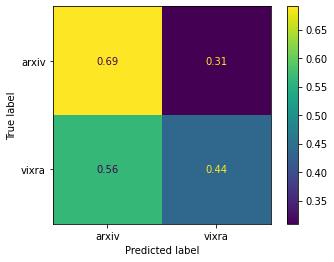

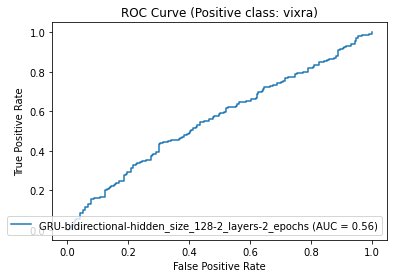

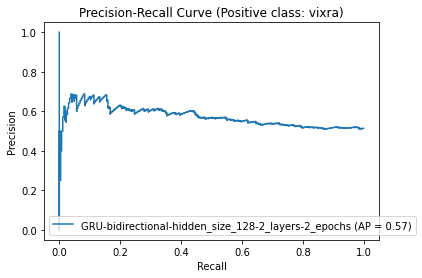

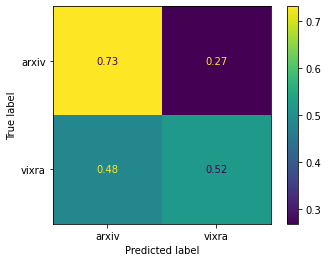

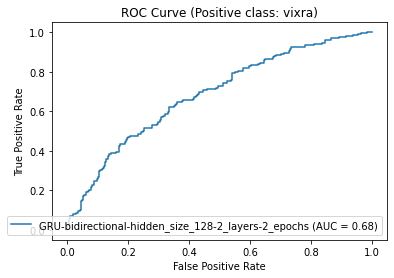

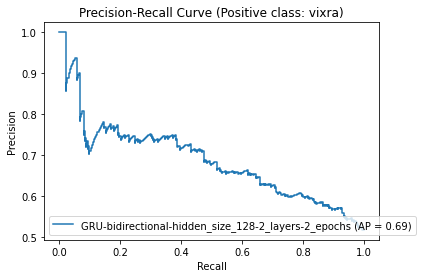

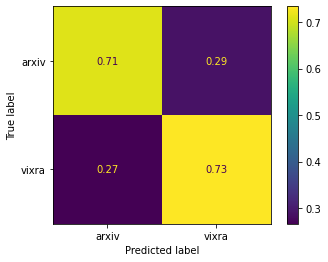

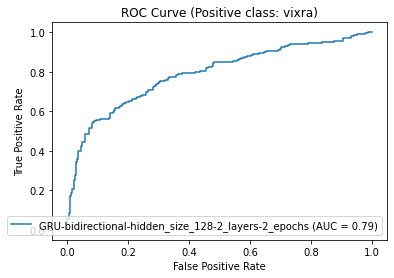

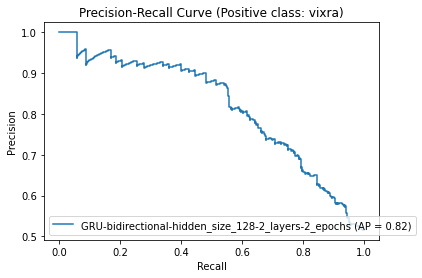

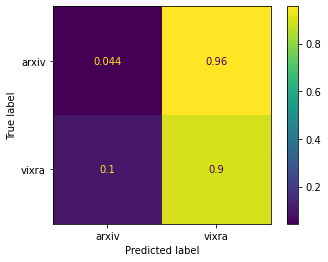

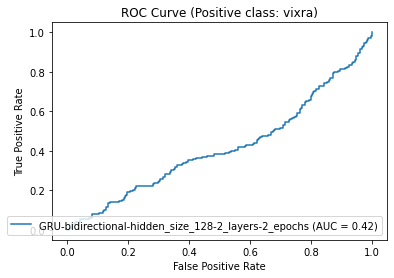

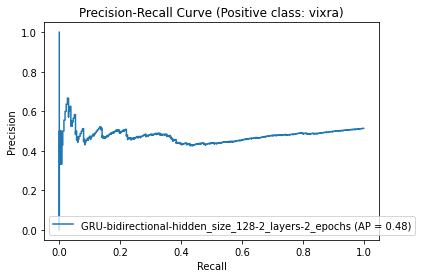

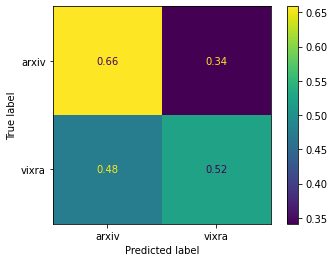

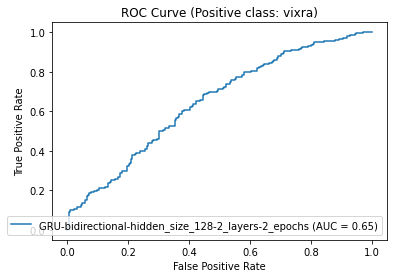

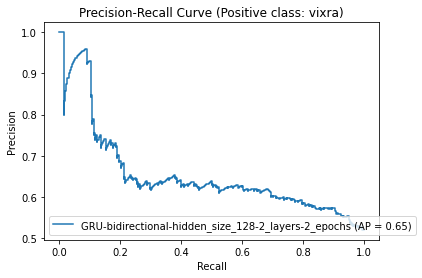

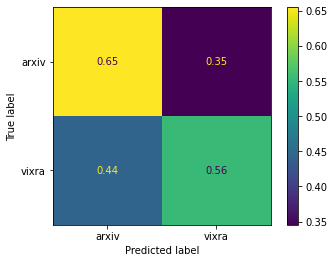

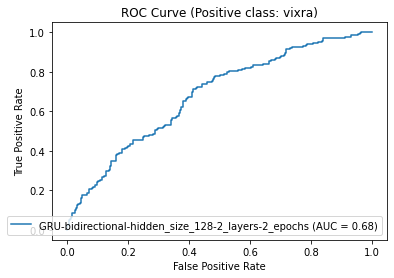

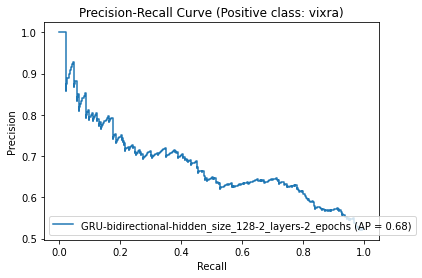

In [21]:
wandb.agent(sweep_id, function=sweep_iteration, count=2)